In [62]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
path_base = "../Data/"

a = 100 #acceleration in steps
hz = 30
samples = 3
stepsize = 20

path = path_base+f"phantom_{stepsize}_{samples}_{a}Accel.csv"

num_meta_rows = 6 
df = pd.read_csv(path, skiprows=num_meta_rows)

new_header = ["Frame", "Time", "X_rot","Y_rot","Z_rot","X_trans","Y_trans","Z_trans"]
df.columns = new_header
# Display the DataFrame
print(df.iloc[1])

Frame        1.000000
Time         0.033333
X_rot       -0.005260
Y_rot       -0.001299
Z_rot        0.005897
X_trans    539.987305
Y_trans    898.596191
Z_trans    264.423157
Name: 1, dtype: float64


In [64]:
# Change rotations to accurate coordinate system and make translations relative to frame 0
translations = ["X_trans", "Y_trans","Z_trans"]
for t in translations:
    df[t] = df[t].subtract(df.iloc[0][t])
print(df.iloc[1])
columns_to_invert = ["X_rot","Z_rot","X_trans","Z_trans"]
df.loc[:, columns_to_invert] *= -1

print(df.iloc[1])

Frame      1.000000
Time       0.033333
X_rot     -0.005260
Y_rot     -0.001299
Z_rot      0.005897
X_trans    0.000183
Y_trans   -0.002320
Z_trans   -0.002350
Name: 1, dtype: float64
Frame      1.000000
Time       0.033333
X_rot      0.005260
Y_rot     -0.001299
Z_rot     -0.005897
X_trans   -0.000183
Y_trans   -0.002320
Z_trans    0.002350
Name: 1, dtype: float64


In [65]:
#SELECT THE DESIRED FRAMES
def find_closest_index(df, target_value):
    # Get the first column of the DataFrame
    first_column = df.iloc[:, df.columns.get_loc("Time")]
    
    # Calculate the absolute differences between each entry and the target value
    absolute_differences = abs(first_column - target_value)
    
    # Find the index of the entry with the smallest absolute difference
    closest_index = absolute_differences.idxmin()
    
    return closest_index

# def get_frames(df, hz, total_frames, offset):
#     new_df = pd.DataFrame(columns=df.columns)

#     target_frames = [i * t_between_frames + offset for i in range(total_frames)]
#     for i in range(len(target_frames)):
#       idx = find_closest_index(df,target_frames[i])
#       #print(type(df.iloc[idx]))
#       new_df.loc[len(new_df)] = df.iloc[idx]

#     return new_df

def get_frames2(df,samples,frame_offset,start_offset): #uses frame number instead of time
    extract = [start_offset  + frame_offset*i for i in range(1,samples+1)] 
    return df[df["Frame"].isin(extract)]

# Code to check if the change if the wobble occurring is beyond a set threshold
def is_stable(frames, t_eps, r_eps):
  rot = abs(frames.iloc[:,-6:-3].max() - frames.iloc[:,-6:-3].min())
  trans = abs(frames.iloc[:,-3:].max() - frames.iloc[:,-3:].min())

  if all(t < t_eps for t in trans) and all(r < r_eps for r in rot):
    return True
  return False

def check_extracted_frames(df,df_extracted,spacing,t_eps,r_eps): #check if extracted frames are not wobling
    bad_frames = []
    good_frames = []
    for i in df_extracted["Frame"]:
        frames_2check = list(range(i-spacing,i)) #check previous frames
        df_2check = df[df["Frame"].isin(frames_2check)]
        if not is_stable(df_2check,t_eps,r_eps):
            bad_frames.append(i)
        else:
           good_frames.append(i)
    return good_frames,bad_frames

In [66]:
colors = ["red","green","blue","red","green","blue"]

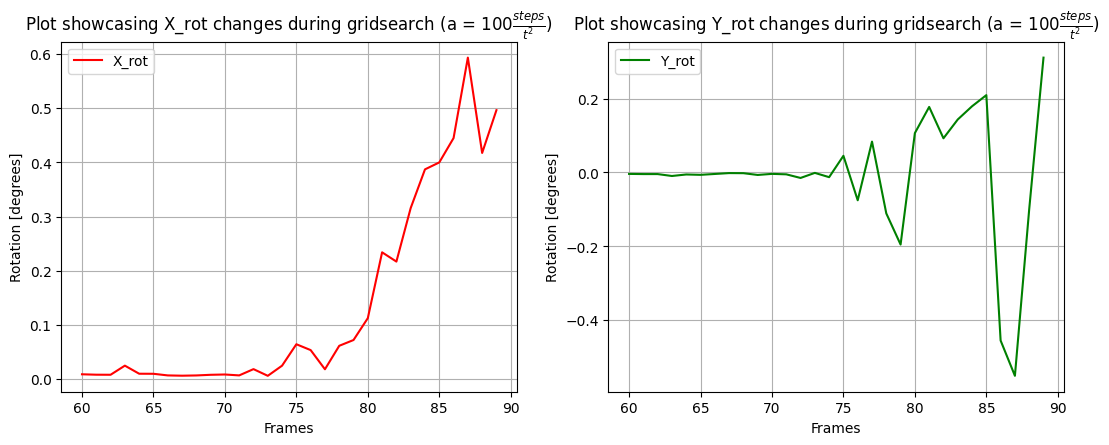

In [67]:
#SELECT THE DESIRED FRAMES (CONT)
plt.figure(figsize=(20,10))
for i in range(2,4):
  plt.subplot(2,3,i-1)
  plt.plot(df.index[60:90], df.iloc[60:90, i], label=df.columns[i],c = colors[i-2])
  plt.title(f"Plot showcasing {df.columns[i]} changes during gridsearch (a = {a}" + r"$\frac{steps}{t^2}$)")
  if "rot" in df.columns[i]:
    plt.ylabel("Rotation [degrees]")
  else:
    plt.ylabel("Translation [mm]")
  
  plt.xlabel("Frames")
  plt.legend()
  plt.grid()
#plt.savefig("test")
plt.show()

In [68]:
#check if some inputs produce similar results
def check_similarity(df,t_eps,r_eps):
  similarities = []
  for i in range(len(df)):
    pos1 = df.iloc[i]
    i_sim = [i]
    for j in range(i+1,len(df)):
      pos2 = df.iloc[j]

      rot = abs(pos1.iloc[-6:-3] - pos2.iloc[-6:-3])
      trans = abs(pos1.iloc[-3:] - pos2.iloc[-3:])

      if  all(t < t_eps for t in trans) and all(r < r_eps for r in rot):
        i_sim.append(j)
    
    if len(i_sim) > 1:
      similarities.append(i_sim)
  
  return similarities
    
#df_dummy = df_valid.iloc[:20]
#print(df_dummy)


if False:
  sim_valid = check_similarity(df_valid,t_eps,r_eps)
  sim_valid_length = [len(x) for x in sim_valid]
  print(f"Amount similar: {len(sim_valid)}")
  if len(sim_valid) > 0:
    print(f"Avg similarity: {np.mean(sim_valid_length)}, Min similarity {min(sim_valid_length)}, Max similarity {max(sim_valid_length)}")
    print(sim_valid)

In [69]:
# Select frames correlating w

start_offset = 65 #(frame before action)
frames_wanted = samples ** 6 #amount of frames to extract
time_offset = 2*hz #time between moves
spacing = 10 #how many previous frames that have to be still
t_eps = 0.5 #translational error
r_eps =0.5 #rotational error


df_extracted = get_frames2(df,frames_wanted,time_offset,start_offset)
valid_idx ,invalid_idx = check_extracted_frames(df,df_extracted,spacing,t_eps,r_eps)
print(f"TOTAL FRAMES: {len(df_extracted)} ({len(valid_idx) + len(invalid_idx)})")
print(f"INVALID FRAMES: {len(invalid_idx)}, VALID FRAMES: {len(valid_idx)}")

df_valid = df_extracted[df_extracted["Frame"].isin(valid_idx)]


TOTAL FRAMES: 729 (729)
INVALID FRAMES: 0, VALID FRAMES: 729


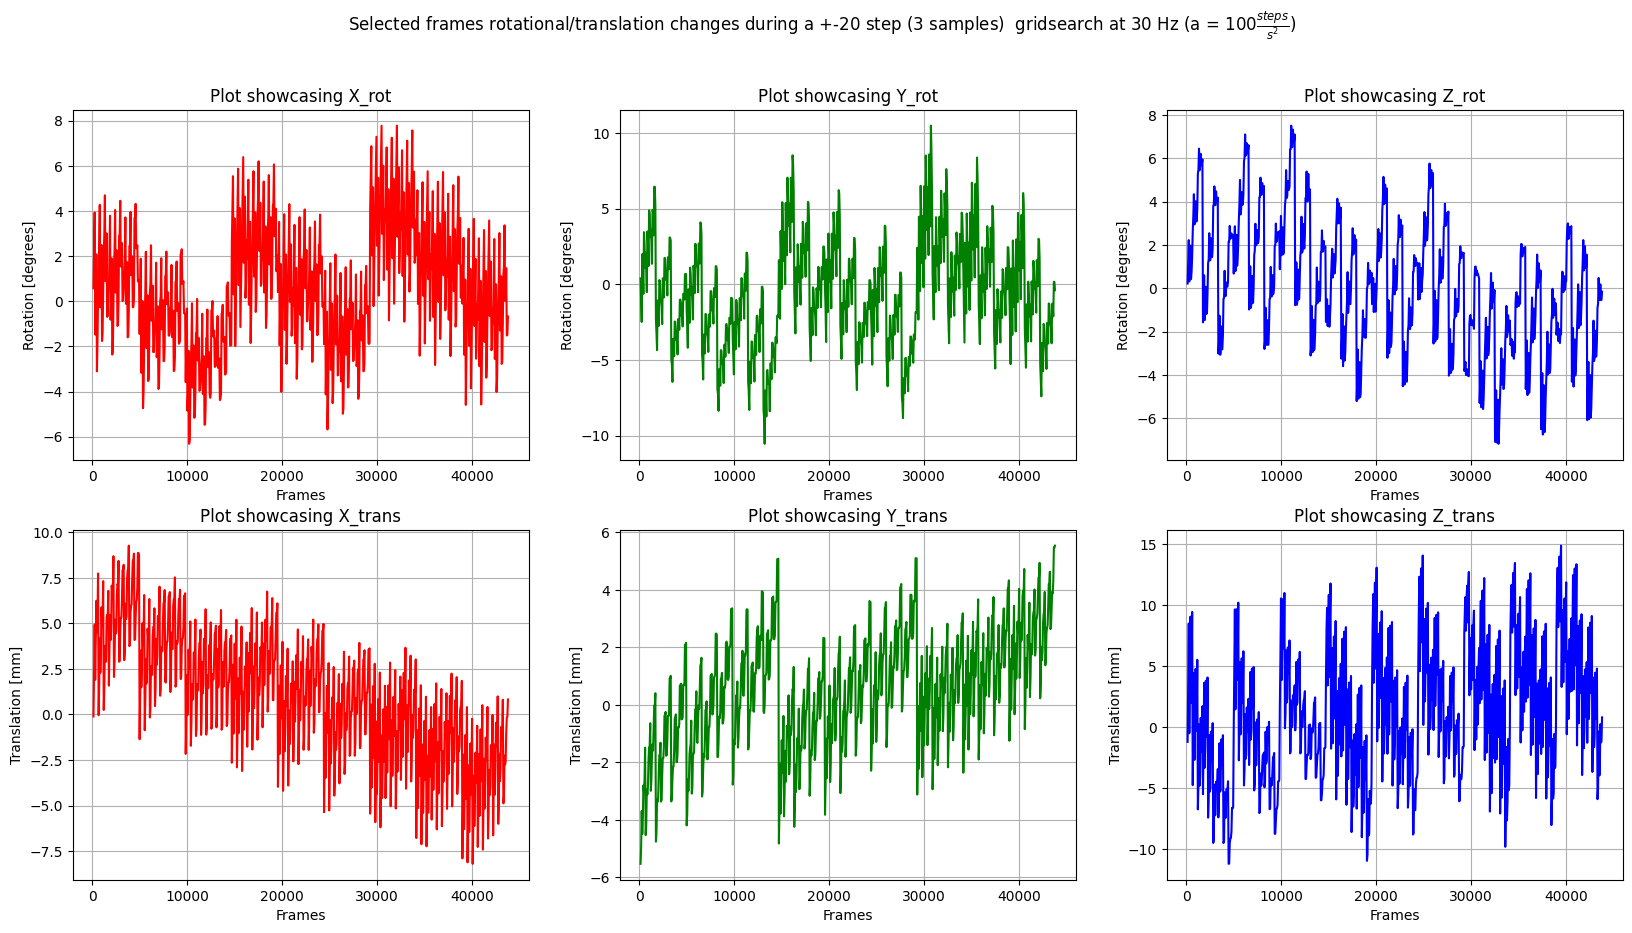

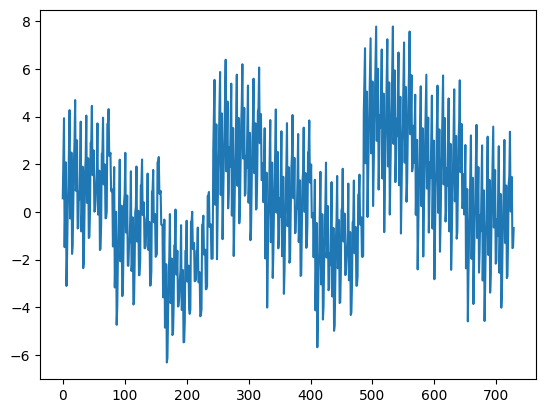

Index([  125,   185,   245,   305,   365,   425,   485,   545,   605,   665,
       ...
       43265, 43325, 43385, 43445, 43505, 43565, 43625, 43685, 43745, 43805],
      dtype='int64', length=729)


In [70]:
#plot the frames just to get an overview
colors = ["red","green","blue","red","green","blue"]
plt.figure(figsize=(20,10))
plt.suptitle(f"Selected frames rotational/translation changes during a +-{stepsize} step ({samples} samples)  gridsearch at {hz} Hz (a = {a}" + r"$\frac{steps}{s^2}$)")
for i in range(2,8):
  plt.subplot(2,3,i-1)
  plt.plot(df_valid.index, df_valid.iloc[:, i], label=df.columns[i],c = colors[i-2])
  plt.title(f"Plot showcasing {df.columns[i]}")
  if "rot" in df.columns[i]:
    plt.ylabel("Rotation [degrees]")
  else:
    plt.ylabel("Translation [mm]")
  plt.grid()
  plt.xlabel("Frames")
  #plt.legend()
#plt.savefig("test")

plt.show()
plt.figure()
plt.plot(np.arange(len(df_valid.index)),df_valid.iloc[:,2])
plt.show()
print(df_valid.index)

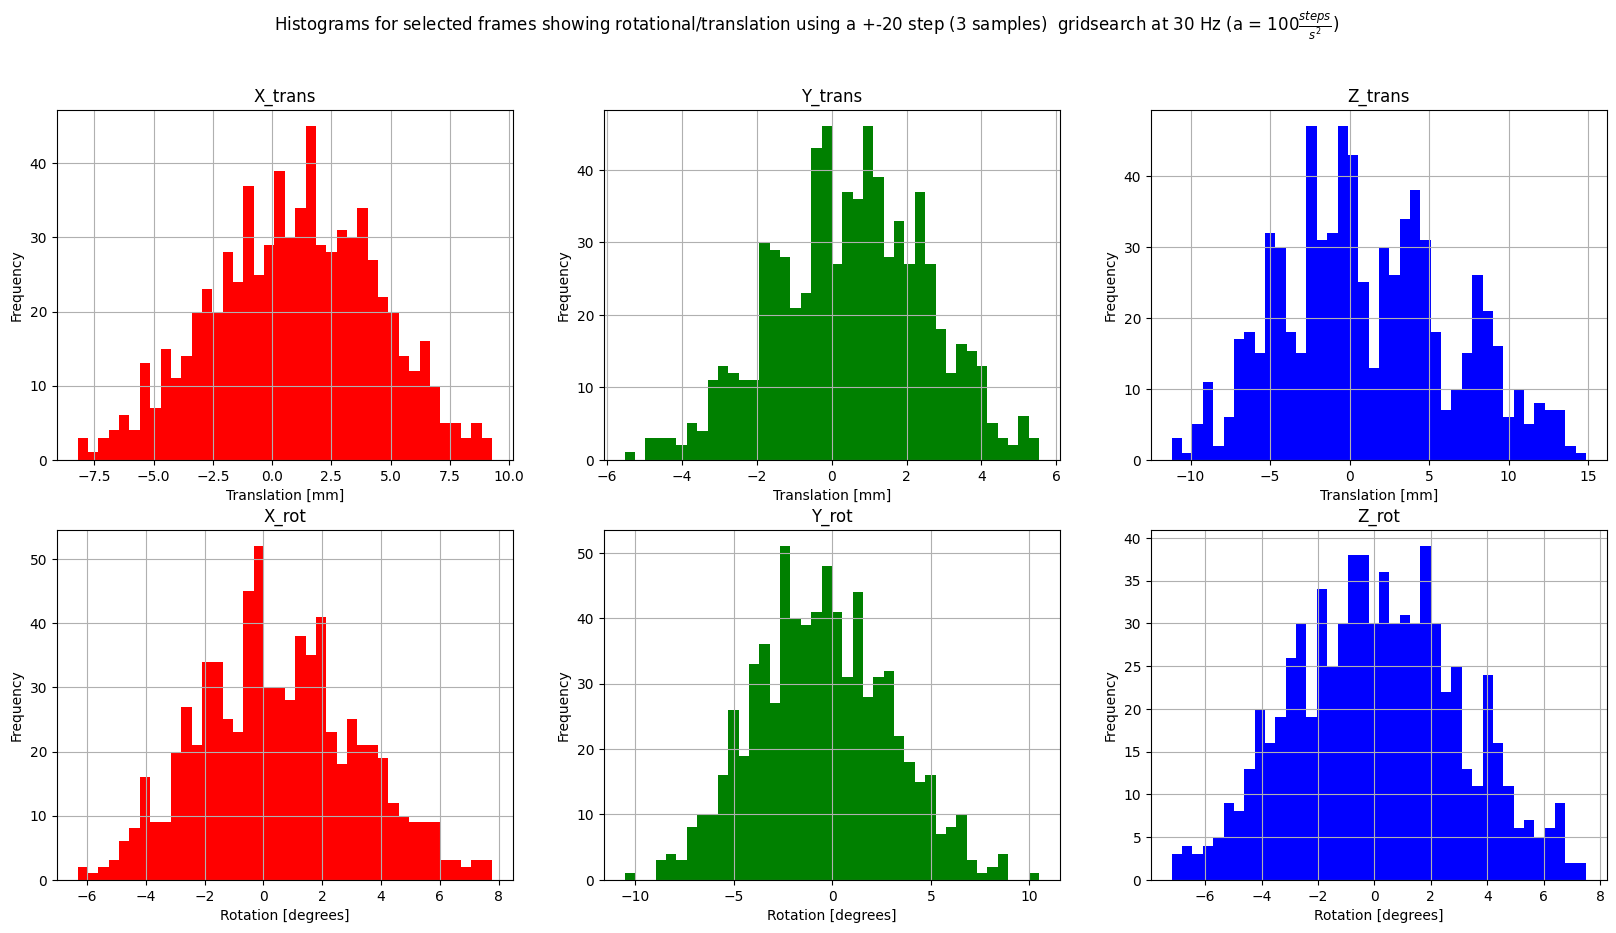

In [71]:
#PLOT DATA DISTRIBUTION FOR EACH ROT TRANS
col = ["X_trans", "Y_trans", "Z_trans", "X_rot", "Y_rot", "Z_rot"]
colors = ["red","green","blue","red","green","blue"]
plt.figure(figsize=(20,10))
bins = 40
plt.suptitle(f"Histograms for selected frames showing rotational/translation using a +-{stepsize} step ({samples} samples)  gridsearch at {hz} Hz (a = {a}" + r"$\frac{steps}{s^2}$)")
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.hist(df_valid[col[i]],bins=bins,color=colors[i])
  plt.title(f"{col[i]}")
  if "rot" in col[i]:
    plt.xlabel("Rotation [degrees]")
  else:
    plt.xlabel("Translation [mm]")

  plt.ylabel("Frequency")
  plt.grid()
plt.show()

In [72]:
#string lengh (in steps) data matching the frames for simple gridsearch
import itertools

# Define the ranges for each number
ranges = [
    range(-stepsize, stepsize+1,stepsize),  # Range for S1
    range(-stepsize, stepsize+1,stepsize),  # Range for S2
    range(-stepsize, stepsize+1,stepsize),  # Range for S3
    range(-stepsize, stepsize+1,stepsize),  # Range for S4
    range(-stepsize, stepsize+1,stepsize),  # Range for S5
    range(-stepsize, stepsize+1,stepsize),  # Range for S6
]

# Generate all combinations
combinations = list(itertools.product(*ranges))
comb_list = list(map(list,combinations))

In [73]:
#ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.spatial.transform import Rotation as R

seed = 42
# Assuming df is your pandas DataFrame
# Normalize translations in DF
col = [ "X_trans", "Y_trans", "Z_trans"]
X_norm = df_valid.copy()
for c in col:
  X_norm[c] = X_norm[col[i]] = 2 * (X_norm[col[i]] - X_norm[col[i]].min()) / (X_norm[col[i]].max() - X_norm[col[i]].min()) - 1
# Selecting features from column index 2 to 7 (exclusive of 8)
X =X_norm.iloc[:, 2:8].values
print(X.shape)


rotations = X[:, :3]
translations = X[:, 3:]
# Define the positions of 4 points spaced around the original pivot point
# These positions are relative to the pivot point before rotation
point_offsets = np.array([[1, 0, 1],  # Point 1
                           [1, 0, -1],  # Point 2
                           [-1, 0, 1], # Point 3
                           [-1, 0, -1]])# Point 4

# Convert Euler angles to rotation matrices
rot_matrices = R.from_euler('xyz', rotations, degrees=True).as_matrix()

# Apply rotation to the point offsets
rotated_points = np.matmul(rot_matrices, point_offsets.transpose())
rotated_points = np.transpose(rotated_points, axes=(0, 2, 1))

for i in range(rotated_points.shape[0]):
  for point in rotated_points[i]:
    point[0] += translations[i,0]
    point[1] += translations[i,1]
    point[2] += translations[i,2]
rotated_points = rotated_points.reshape(-1,12)

X = rotated_points #np.concatenate((rotated_points, translations), axis=1)
# 12 features, xyz xyz xyz xyz
min_xs, max_xs = min([np.min(X[:,0]),np.min(X[:,3]),np.min(X[:,6]),np.min(X[:,9])]), max([np.max(X[:,0]),np.max(X[:,3]),np.max(X[:,6]),np.max(X[:,9])])
min_ys, max_ys = min([np.min(X[:,1]),np.min(X[:,4]),np.min(X[:,7]),np.min(X[:,10])]), max([np.max(X[:,1]),np.max(X[:,4]),np.max(X[:,7]),np.max(X[:,10])])
min_zs, max_zs = min([np.min(X[:,2]),np.min(X[:,5]),np.min(X[:,8]),np.min(X[:,11])]), max([np.max(X[:,2]),np.max(X[:,5]),np.max(X[:,8]),np.max(X[:,11])])

print(min_xs,max_xs)
print(min_ys,max_ys)
print(min_zs,max_zs)
print(X.shape)

#normalize all vectors based on their max/min x,y or z value
for i in range(X.shape[0]):
  for x in [0,3,6,9]:
    X[i,x] = ((X[i,x]-min_xs)/(max_xs-min_xs)) - 1
  for y in [1,4,7,10]:
    X[i,y] = ((X[i,y]-min_ys)/(max_ys-min_ys)) -1
  for z in [2,5,8,11]:
    X[i,z] = ((X[i,z]-min_zs)/(max_zs-min_zs)) -1






















# Assuming your output targets are in the columns from index 8 onwards
Y = np.array(comb_list)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=seed)

# Initialize the RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=seed)

# Specify the number of folds for cross-validation
k_folds = 5

# Initialize the KFold cross-validator
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# # Initialize list to store validation MSE scores
# validation_mse_scores = []

# # Iterate over each fold
# for train_index, val_index in kf.split(X_train):
#     # Split the data into training and validation sets for this fold
#     X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
#     y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
#     # Fit the model on the training data
#     random_forest.fit(X_train_fold, y_train_fold)
    
#     # Predict on the validation set
#     y_pred = random_forest.predict(X_val_fold)
    
#     # Compute MSE for this fold
#     mse = mean_squared_error(y_val_fold, y_pred)
#     validation_mse_scores.append(mse)

# # Print the validation MSE scores
# print("Validation MSE scores:", validation_mse_scores)
# print("Mean Validation MSE:", np.mean(validation_mse_scores))
# print("Std Validation MSE:", np.std(validation_mse_scores))

# Train the model
# random_forest.fit(X_train, y_train)

# # Predict on the test set
# y_pred = random_forest.predict(X_test)
# #print(y_pred[0])
# #print(y_test[0])
# #print(y_pred - y_test)

# # Calculate and print the Mean Squared Error
# ref = np.zeros(6)
# mse_base = np.mean((ref-y_test)**2)

# print(f"MSE Random Forest for each cable {np.mean((y_pred-y_test)**2, axis = 0)}")
# #print(np.mean(np.mean((y_pred-y_test)**2, axis = 0)))
# mse_rf = np.mean((y_pred - y_test) ** 2)
# print("MSE Baseline:", mse_base)
# print("MSE Random Forest:", mse_rf)

(729, 6)
-9.250321744926588 10.326785306708736
-5.544474109832005 5.557270861920189
-12.222205232304447 15.899410789061267
(729, 12)


In [74]:
print(df_valid.max())
print(df_valid.min())

Frame      43805.000000
Time        1460.166667
X_rot          7.778208
Y_rot         10.491430
Z_rot          7.510272
X_trans        9.275269
Y_trans        5.542541
Z_trans       14.873856
dtype: float64
Frame      125.000000
Time         4.166667
X_rot       -6.316861
Y_rot      -10.544286
Z_rot       -7.188015
X_trans     -8.202880
Y_trans     -5.530762
Z_trans    -11.188171
dtype: float64


In [75]:
#Regularize the input data
def steps_to_mm(steps):
  return steps *15*np.pi/200


#max_dist = steps_to_mm(100)
#min_dist = steps_to_mm(-100)

#based
#max_vals = [20, 20, 20, 15, 15, 15]#[2,2.5,10,7.5,]
#min_vals = [-20, -20, -20, -15, -15, -15]#[-2,-7,-3.5,-11]

# X = shape (729,15)

# X_norm = df_valid[col].copy()
# #print(X_norm.head)
# #print(X_norm)


# for i in range(6):
#   #X_norm[col[i]] = (X_norm[col[i]]-X_norm[col[i]].min()) / (X_norm[col[i]].max()-X_norm[col[i]].min())
#   #X_norm[col[i]] =X_norm[col[i]] - X_norm[col[i]].mean()
#   # mean_value = X_norm[col[i]].mean()
#   # std_value = X_norm[col[i]].std()

#   # # Z normalize the column
#   # X_norm[col[i]] = (X_norm[col[i]] - mean_value) / std_value
#   # X_norm[col[i]] = X_norm[col[i]] - X_norm[col[i]].mean()
#   X_norm[col[i]] = 2 * (X_norm[col[i]] - X_norm[col[i]].min()) / (X_norm[col[i]].max() - X_norm[col[i]].min()) - 1

# #print(X_norm)
# print(X_norm.max())
# print(X_norm.min())
# #print(df_valid.min())
# #X_norm = (X - min_vals) / (max_vals-min_vals)

# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_norm.values, Y, test_size=0.15, random_state=seed)

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        #self.bn1 = nn.BatchNorm1d(6)
        self.fc1 = nn.Linear(input_size, hidden_size)
        #self.bn2 = nn.BatchNorm1d(30)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        #self.bn3 = nn.BatchNorm1d(30)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        #self.bn4 = nn.BatchNorm1d(30)
        self.dropout3 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(hidden_size, output_size)

        #self.fc5 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        #x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        #x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        #x = self.dropout3(x)
        x = self.fc4(x)
        return x

# Define input and output sizes
input_size = 12
output_size = 6
hidden_size = 32#64
batch_size = 4
lr = 0.001
num_epochs = 500

# Create the model
model = FeedForwardNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

In [77]:
#SETUP DATALOADERS
from torch.utils.data import TensorDataset, DataLoader

def create_data_loaders(train_index, val_index):
    X_train_fold,y_train_fold = torch.tensor(X_train[train_index], dtype=torch.float32), torch.tensor(y_train[train_index], dtype=torch.float32)
    X_val_fold,y_val_fold = torch.tensor(X_train[val_index], dtype=torch.float32), torch.tensor(y_train[val_index], dtype=torch.float32)
    train_dataset = TensorDataset(X_train_fold,y_train_fold)
    val_dataset = TensorDataset(X_val_fold,y_val_fold)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

# train_data_tensor = torch.tensor(X_train, dtype=torch.float32)
# targets_tensor = torch.tensor(y_train, dtype=torch.float32)
# val_data_tensor = torch.tensor(X_test, dtype=torch.float32)
# val_targets_tensor = torch.tensor(y_test, dtype=torch.float32)

# # Combine the input data and target values into a TensorDataset
# train_dataset = TensorDataset(train_data_tensor, targets_tensor)
# test_dataset = TensorDataset(val_data_tensor, val_targets_tensor)

# # Create a DataLoader for batch processing
# batch_size = 4
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [78]:
#TRAINING
# Lists to store training and validation losses
train_losses = []
val_losses = []
i = 0
for train_index, val_index in kf.split(X_train):


    # Initialize early stopping parameters
    # best_val_loss = np.Inf
    # patience = 15
    # counter = 0
    # Create the model
    model = FeedForwardNN(input_size, hidden_size, output_size)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed
    train_losses_fold = []
    val_losses_fold = []
    train_loader,val_loader = create_data_loaders(train_index, val_index)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_train_loss = 0.0
        
        # Training loop
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        # Compute average training loss for the epoch
        average_train_loss = running_train_loss / len(train_loader)
        train_losses_fold.append(average_train_loss)
        
        # Validation loop
        model.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
        
        # Compute average validation loss for the epoch
        average_val_loss = running_val_loss / len(val_loader)
        val_losses_fold.append(average_val_loss)

         # Check for improvement in validation loss
        # if running_val_loss < best_val_loss:
        #     best_val_loss = running_val_loss
        #     counter = 0
        #     # Save the best model state if needed
        #     # torch.save(model.state_dict(), 'best_model.pt')
        # else:
        #     counter += 1
        #     # If no improvement for patience epochs, stop training
        #     if counter >= patience:
        #         print(f'Early stopping at epoch {epoch}.')
        #         break
        
        # Print training and validation loss for the epoch
        print(f"Fold: {i}, Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}", end = "\r")
    i += 1
    train_losses.append(train_losses_fold)
    val_losses.append(val_losses_fold)

# Plot the training and validation losses
plt.figure()
for i in range(k_folds):
    plt.plot(train_losses[i], label='Train Loss')
    plt.plot(val_losses[i], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
#x[-1] for x in 

In [ ]:
# # (5,100)
# #print(np.array(train_losses).shape)
# for i in range(5):
#   print(val_losses[i][-1])
# # print(train_losses[:][1])
# # print(train_losses[1])
# # print(train_losses)

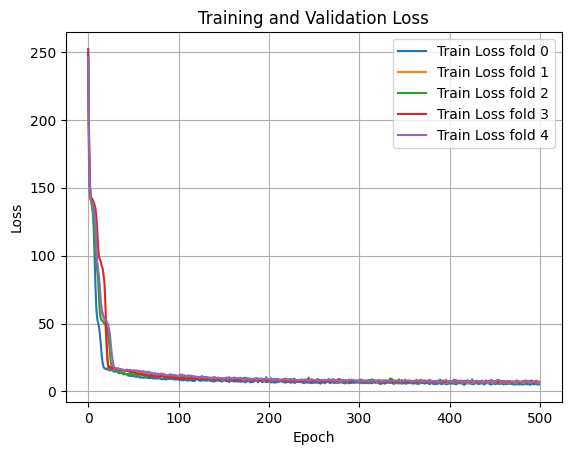

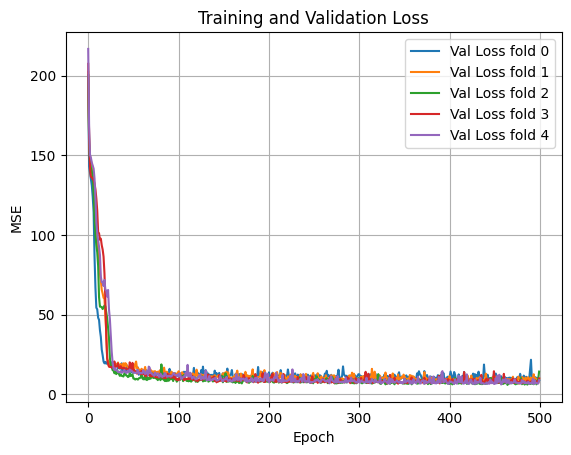

Mean Training MSE: 6.3714734752332, Mean Training STD: 0.6232731458536083
Mean Validation MSE: 10.367645645910693, Mean Validation STD: 2.007006819815639


In [ ]:
plt.figure()
for i in range(k_folds):
    plt.plot(train_losses[i], label=f'Train Loss fold {i}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure()
for i in range(k_folds):
    plt.plot(val_losses[i], label=f"Val Loss fold {i}")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()
print(f"Mean Training MSE: {np.mean(np.array(train_losses)[:,-1])}, Mean Training STD: {np.std(np.array(train_losses)[:,-1])}")
print(f"Mean Validation MSE: {np.mean(np.array(val_losses)[:,-1])}, Mean Validation STD: {np.std(np.array(val_losses)[:,-1])}")

In [ ]:
np.save("data/20_new/3hid_32_neu_500epoch_p001lr_marker_norm_trainloss",np.array(train_losses))
np.save("data/20_new/3hid_32_neu_500epoch_p001lr_marker_norm_valloss",np.array(val_losses))

In [ ]:
# Lists to store training and validation losses

# Create the model
model = FeedForwardNN(input_size, hidden_size, output_size)



# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

train_data_tensor = torch.tensor(X_train, dtype=torch.float32)
targets_tensor = torch.tensor(y_train, dtype=torch.float32)
val_data_tensor = torch.tensor(X_test, dtype=torch.float32)
val_targets_tensor = torch.tensor(y_test, dtype=torch.float32)
# Combine the input data and target values into a TensorDataset
train_dataset = TensorDataset(train_data_tensor, targets_tensor)
test_dataset = TensorDataset(val_data_tensor, val_targets_tensor)

# Create a DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0
    
    # Training loop
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    
    # Compute average training loss for the epoch
    average_train_loss = running_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()
    
    # Compute average validation loss for the epoch
    average_val_loss = running_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    
    # Print training and validation loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}", end = "\r")

In [ ]:
# #SAVE MODEL
model_name = "3hid_32_neu_500epoch_p001lr_marker_norm"
torch.save(model, "models/"+ model_name + ".pth")